# 自己符号化器
とは、教師ラベル(正解ラベル)のない、教師なし学習に分類される学習方法。  
正解のない入力だけの訓練データを用いて、学習させつつデータをよく表現する特徴を抽出してくることが目的となる。  
深層学習、いわゆるディープラーニングの事前学習、すなわち重みの良い初期値を得るために用いられることもある。  

## 概要
入力層と出力層のニューロンが同数の、中間層を含む順伝搬型のニューラルネットを考えます。  
入力層と出力層のニューロンが同数なので、入力データと全く同じ出力結果を得そうなものですが、味噌は中間層になります。  
※味噌の詳細としては、中間層前後にある活性化関数や重み、閾値になります  
  
訓練データ$x_{1}, x_{2}, ... , x_{N}$が与えられたときに、各サンプル$x_{n}$を入力したときのネットワークの出力$\hat x_{n}$が、  
$x_{n}$に平均的に近くなる様に学習を行います。  
  
学習には、後ほど説明する誤差関数を確率的勾配降下法で最小化していきます。  
  
ここで自己符号化で焦点を当てたいのは、こうして訓練したネットワークにある入力$x$を与えたときの、中間層の出力$y$にあります。  
$x$に対して決まる$y$のことを、$x$の**符号**(code)とみなし、  
最初の変換$y=f(Wx+b)$を**符号化**(encode), 最後の変換$\hat x=\tilde f(\tilde W y+\tilde b)$を**復号化**(decode)と呼びます。 
  
数学的な知見は省略するとして、  
**学習の目的は、狙いは入力データを符号化し、続けて復号化することで、元の入力データがなるべく忠実に再現されるような符号化の方法を  
定めることにあります。**  
このような働きをもつニューラルネットのことを、**自己符号化器(auto-encoder)**といいます。

## 自己符号化器 ネットワークの設計
自己符号化器の活性化関数として、中間層と出力層の活性化関数をそれぞれ$f$, $\tilde f$とします。  
ここで中間層の活性化関数$f$は自由に決めることができ、通常は非線形な関数を選択します。  
出力層の活性化関数$\tilde f$は、その目標出力が入力したデータ$x$自身に近似できるように入力データの種類に応じて選びます。  
誤差関数については、入力$x$と出力$\hat x$の近さの尺度となる関数を選択します。  

$x$の各成分$x_{i}$が実数値をとり、その値の範囲に制約がないものとします。  
このとき、出力層の活性化関数$\tilde f$を恒等写像(変化をおよぼさない変換)とするのが一般的です。  
($x$の成分が、0,1の2値をとる場合、$\tilde f$はロジスティック関数を用いる等々)  
  
そうすると、誤差関数には、入出力間の二乗誤差の総和  
  
$$
E(w) = \sum_{n=1}^{N}\parallel x_{n} - \hat x (x_{n}) \parallel ^{2}
$$
  
を用いることになります。  
ここで$w$は、ネットワークの重みとバイアスの成分すべて${W, b, \tilde W, \tilde b}$をベクトルにしたものになります

**重みの共有**  
入力層と中間層のユニット数をそれぞれ、$D_{x}$, $D_{y}$とすると、$W$, $\tilde W$のサイズはそれぞれ $D_{y}\times D_{x}$, $D_{x}\times D_{y}$になります。  
一般的には、この入力層と中間層の重みは異なるものですが、$\tilde W= W^{T}$のように共通する場合もあります(重みの共有)  
重みを共有にする場合と、しない場合が明確に判断できるケースは知られてないですが、  
学習の結果として得られた二つの重みが共通である式に近似している場合があります。  

## Kerasを用いて実装してみる

In [1]:
import numpy as np
import matplotlib.pyplot as plt

**必要なデータとして、今回もMNISTオープンデータをインポート**

In [2]:
# kerasから"MNIST"(0~9の数字が描かれた画像データ)をロードする
from keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

In [3]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

**"0"~"9"の10種類の画像データが、それぞれ6000枚*10セット=60,000枚の学習用データ＆1000枚*10セットの検証用データ**

In [4]:
# 学習用データ、0番目の配列(28*28)
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

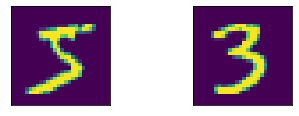

In [5]:
#print(x_train[0].shape)

# 学習用データ0番目の画像データ可視化(左)
ax = plt.subplot(2, 2, 1)
plt.imshow(x_train[0])
#plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# 学習用データ10001番目の画像データ可視化(右)
ax = plt.subplot(2, 2, 2)
plt.imshow(x_train[10000])
#plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [6]:
# 入力データの準備、正規化
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [7]:
# 正規化された学習用データ、0番目の配列(28*28)
x_train[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [8]:
# MNISTのデータには、教師データとしてのラベルが貼られているが、
# 今回は入力データの、エンコード・デコードのみに限られるので、あらかじめ学習用＆検証用データから除去
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


### Simple Auto Encoder、いわゆる単純な自己符号化器を作る

In [9]:
from keras.layers import Input, Dense
from keras.models import Model

**説明の便宜上、細かくコードを区切るけれど、実際はひとまとめに書いたりする**

In [10]:
# 入力層の圧縮(エンコード)のための次元数を決める、ここでは"32"とする。すると、入力層の圧縮率は 784/32=24.5 
encoding_dim = 32

In [11]:
# 入力層(Input)に入力される画像(img)の形状(shape=(784,))を定義
input_img_1 = Input(shape=(784,))

In [12]:
# "encoded" 入力の符号化表現。活性化関数に"relu"を指定
encoded_1 = Dense(encoding_dim, activation='relu')(input_img_1)

In [13]:
# "decoded" 入力の損失を考慮して、再構築する。活性化関数に"sigmoid"を指定
decoded_1 = Dense(784, activation='sigmoid')(encoded_1)

In [14]:
# Auto-EncoderとしてのModelに対して、入力層を再構成してマッピング
autoencoder_1 = Model(input_img_1, decoded_1)

In [15]:
# このモデルが入力を符号化された表現に写像するように定義
encoder_1 = Model(input_img_1, encoded_1)

In [16]:
# エンコードされる（32次元の）入力層を作成
encoded_input_1 = Input(shape=(encoding_dim,))

In [17]:
# エンコーダーモデルの最後のレイヤーを取得
decoder_layer_1 = autoencoder_1.layers[-1]

In [18]:
# 出力層を構成する
decoder_1 = Model(encoded_input_1, decoder_layer_1(encoded_input_1))

In [19]:
# ピクセルごとにバイナリクロスエントロピー損失とAdadeltaオプティマイザを使用する(任意)
# オプティマイザと損失関数については、今回は下記のように設定
autoencoder_1.compile(optimizer='adadelta', loss='binary_crossentropy')

In [20]:
autoencoder_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


**定義したものはこんな感じ**  
中間層を、ギュッと絞った自己符号化器を試してみる

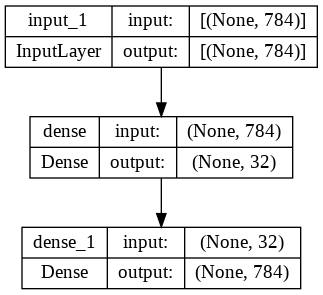

In [21]:
from keras.utils.vis_utils import plot_model
plot_model(autoencoder_1, to_file="architecture_simple.png", show_shapes=True)

`from keras.utils.vis_utils import plot_model`  
を利用すると、もうちょっと直感的にわかりやすく可視化できます  
**ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.**  
とインポートエラーを吐く場合は、環境下で "pip install pydot" or "conda install pydot"などで適時、インポートしてください

**あとは、用意した学習用データと検証用データを使って、訓練させます。**  
**この時に時間がもったいないので、前回学んだEarly Stopping(学習の早期打ち切り)を利用します。**  

In [22]:
from keras.callbacks import EarlyStopping

In [23]:
# Early-stopping 
early_stopping = EarlyStopping(patience=5, verbose=5) 

In [24]:
# 学習
# - バッチサイズ：256
# - 学習の繰り返し回数：50
his = autoencoder_1.fit(x_train, x_train,
                        epochs=50,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(x_test, x_test),
                        callbacks=[early_stopping])

Epoch 1/50
235/235 [==============================] - 2s 4ms/step - loss: 0.6945 - val_loss: 0.6944
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 0.6943 - val_loss: 0.6942
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 0.6942 - val_loss: 0.6941
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.6940 - val_loss: 0.6940
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.6939 - val_loss: 0.6938
Epoch 6/50
235/235 [==============================] - 1s 5ms/step - loss: 0.6938 - val_loss: 0.6937
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 8/50
235/235 [==============================] - 1s 4ms/step - loss: 0.6935 - val_loss: 0.6934
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 0.6934 - val_loss: 0.6933
Epoch 10/50
235/235 [==============================] - 1s 4ms/step - loss: 0.6932 - val_loss: 0.6932

**今回は早期打ち切りが効果を発揮する前に繰り返しの訓練($epochs=50$)が完了しました**  
"教師なし"なので、当然と言えば当然なのかもしれませんが、単純にもっと繰り返し訓練してもいいのかもしれません。

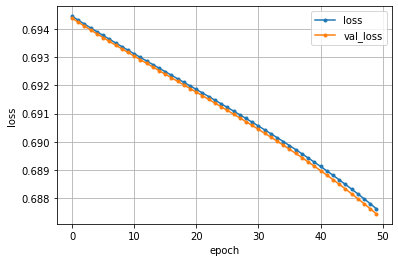

In [25]:
### 訓練過程の可視化
loss = his.history['loss']
val_loss = his.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

**さて、もともとの画像データを、この自己符号化器に入れるとどの様になるのでしょうか？？気になるところです**  
検証用データから、エンコード・デコードして可視化してみます。

In [26]:
# 画像データをエンコードしてデコード
encoded_imgs_1 = encoder_1.predict(x_test)
decoded_imgs_1 = decoder_1.predict(encoded_imgs_1)

313/313 [==============================] - 0s 1ms/step


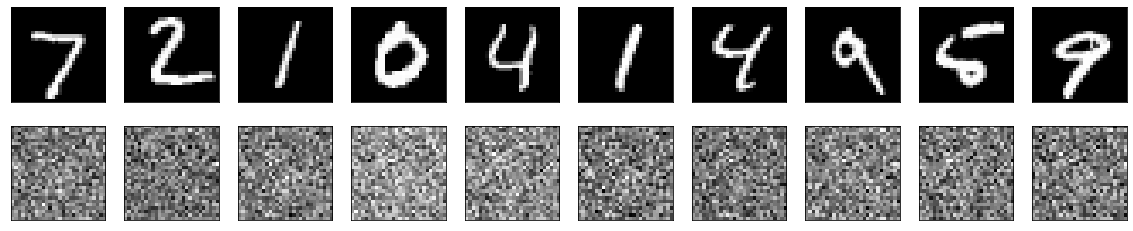

In [27]:
n = 10  # 横方向に描画する画像の数を設定
plt.figure(figsize=(20, 4))
for i in range(n):
    # オリジナルの画像データ
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # エンコード・デコードした画像データ
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_1[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

上の列が、オリジナルの画像データで、下の列がエンコード・デコードした画像データ。  
エンコード・デコードすると、ぼやっとしている様に見えますが、これがオリジナルの画像データの特徴を示しているものになります。  
ぼやっとしている要因には、単純に中間層でギュッと絞ったエンコードをしているからです。  
もう少し丁寧にいえば、中間層のユニット数32に対して、入力データの次元(自由度は)784となって自由度が小さくなっていることを反映しています。

上記のコード、  
`encoded_imgs_1 = encoder_1.predict(x_test)
decoded_imgs_1 = decoder_1.predict(encoded_imgs_1)`  
は、やや冗長なコード(説明のため)になってますが、下記のように出力させるのが一般的かなと思います。

In [28]:
decoded_imgs_1 = autoencoder_1.predict(x_test)

313/313 [==============================] - 0s 1ms/step


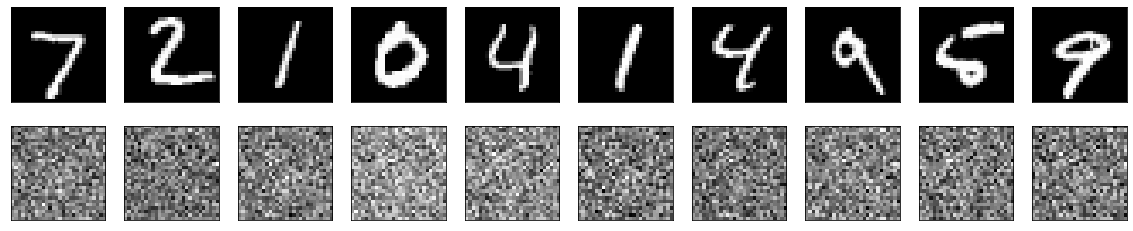

In [29]:
n = 10  # 横方向に描画する画像の数を設定
plt.figure(figsize=(20, 4))
for i in range(n):
    # オリジナルの画像データ
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # エンコード・デコードした画像データ
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_1[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

[追加的な要素]
### Simple Auto-Encoder adding a sparsity constraint   on the encoded representations

Simple Auto Encoderでは、表現は隠れ層のサイズによってのみ制約されてました  
この背景としては、隠れ層がPCA（主成分分析）の近似を学習していることが主な理由となります    
**しかし表現をコンパクトに制約する別の方法として、隠れ層の活性化関数に希薄性の制約(正則化)を加えることで、**  
**与えられた時間内で逆伝搬するユニットを少なくする手法**があります  
**Kerasでは、"activity_regularizer"をDenseレイヤーに追加することでこれを行うことができます**

In [30]:
from keras import regularizers

In [31]:
encoding_dim = 32
input_img = Input(shape=(784,))

# activity regularizerを加える
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(1e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder_addingSparsity = Model(input_img, decoded)

autoencoder_addingSparsity.compile(optimizer='adam', loss='binary_crossentropy')
his = autoencoder_addingSparsity.fit(x_train, x_train,
                                     epochs=100,
                                     batch_size=256,
                                     shuffle=True,
                                     validation_data=(x_test, x_test), 
                                     callbacks=[early_stopping])

Epoch 1/100
235/235 [==============================] - 1s 4ms/step - loss: 0.2752 - val_loss: 0.1861
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - loss: 0.1693 - val_loss: 0.1528
Epoch 3/100
235/235 [==============================] - 1s 3ms/step - loss: 0.1440 - val_loss: 0.1337
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - loss: 0.1291 - val_loss: 0.1221
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - loss: 0.1195 - val_loss: 0.1148
Epoch 6/100
235/235 [==============================] - 1s 3ms/step - loss: 0.1130 - val_loss: 0.1092
Epoch 7/100
235/235 [==============================] - 1s 3ms/step - loss: 0.1082 - val_loss: 0.1051
Epoch 8/100
235/235 [==============================] - 1s 3ms/step - loss: 0.1046 - val_loss: 0.1018
Epoch 9/100
235/235 [==============================] - 1s 3ms/step - loss: 0.1019 - val_loss: 0.0995
Epoch 10/100
235/235 [==============================] - 1s 3ms/step - loss: 0.0999 - val_lo

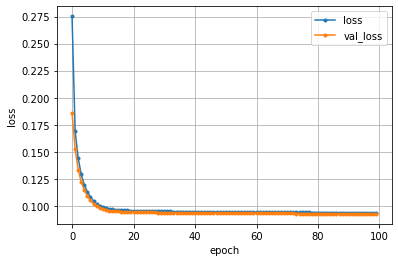

In [32]:
### 訓練過程の可視化
loss = his.history['loss']
val_loss = his.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

**先ほどは、早期打ち切り前に訓練が完了してしまったので、$epochs=100$でやってみました。**  
**今回の場合では、54回目に訓練が早期打ち切りとなりました。**  
正則化(Sparsed)することで、逆伝搬の計算が簡素になるので計算が早く終わるかなと思いきや、若干計算が重くなりつつ、  
訓練指標のloss, val_lossも対して良いわけでもない。  

In [33]:
decoded_imgs_1 = autoencoder_addingSparsity.predict(x_test)

313/313 [==============================] - 0s 1ms/step


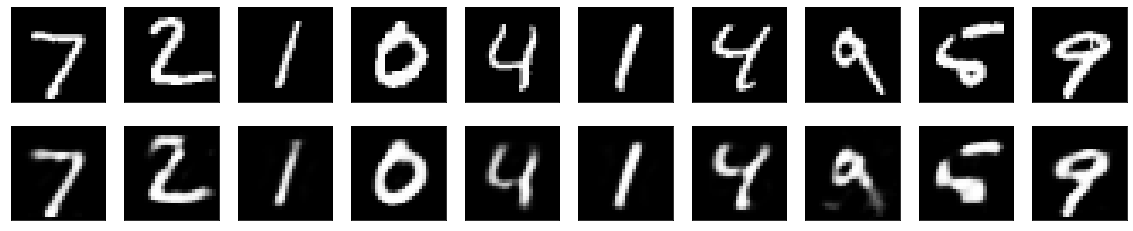

In [34]:
n = 10  # 横方向に描画する画像の数を設定
plt.figure(figsize=(20, 4))
for i in range(n):
    # オリジナルの画像データ
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # エンコード・デコードした画像データ
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_1[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**可視化してみると、先ほどのSimple Auto-Encoderよりもやっとした感じ。**  
**正則化の効果については、次に説明します。**  
いったん、まとめると、

**自己符号化器の目的は**  
このような特徴を抽出する学習を介して、サンプル$x$の別のよく近似できる$y$を得ることです。  
ただし、何が良い表現であるかは問われません。(別途、相対的に定義することはありますが、単体ではわかり得ない)  
直感的には、$x$をそのまま使うよりも、変換して$y$を用いると対象とする問題が解決する場合などがあります。  
例えば、サポートベクタマシンを使ってクラス分類する際に、$x$をその対象とするよりも、$y$を用いた方が性能が向上するといったことです。

In [35]:
# 入力層の圧縮(エンコード)のための次元数を決めるが、圧縮を784/(784*2) = 0.5にしてみる
encoding_dim = 784*2

input_img_1 = Input(shape=(784,))
encoded_1 = Dense(encoding_dim, activation='relu')(input_img_1)
decoded_1 = Dense(784, activation='sigmoid')(encoded_1)

autoencoder_2 = Model(input_img_1, decoded_1)

encoder_1 = Model(input_img_1, encoded_1)
encoded_input_1 = Input(shape=(encoding_dim,))

decoder_layer_1 = autoencoder_2.layers[-1]

decoder_1 = Model(encoded_input_1, decoder_layer_1(encoded_input_1))

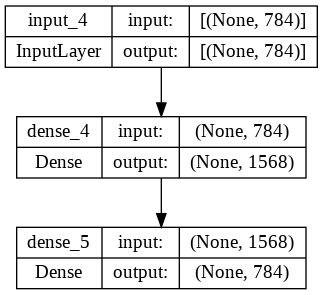

In [36]:
autoencoder_2.compile(optimizer='adadelta', loss='binary_crossentropy')
plot_model(autoencoder_2, to_file="architecture_simple2.png", show_shapes=True)

In [37]:
his = autoencoder_2.fit(x_train, x_train,
                        epochs=100,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(x_test, x_test),
                        callbacks=[early_stopping])

Epoch 1/100
235/235 [==============================] - 1s 5ms/step - loss: 0.6960 - val_loss: 0.6948
Epoch 2/100
235/235 [==============================] - 1s 4ms/step - loss: 0.6936 - val_loss: 0.6924
Epoch 3/100
235/235 [==============================] - 1s 4ms/step - loss: 0.6913 - val_loss: 0.6901
Epoch 4/100
235/235 [==============================] - 1s 4ms/step - loss: 0.6889 - val_loss: 0.6877
Epoch 5/100
235/235 [==============================] - 1s 4ms/step - loss: 0.6866 - val_loss: 0.6854
Epoch 6/100
235/235 [==============================] - 1s 4ms/step - loss: 0.6844 - val_loss: 0.6831
Epoch 7/100
235/235 [==============================] - 1s 4ms/step - loss: 0.6821 - val_loss: 0.6807
Epoch 8/100
235/235 [==============================] - 1s 4ms/step - loss: 0.6798 - val_loss: 0.6784
Epoch 9/100
235/235 [==============================] - 1s 4ms/step - loss: 0.6775 - val_loss: 0.6761
Epoch 10/100
235/235 [==============================] - 1s 4ms/step - loss: 0.6753 - val_lo

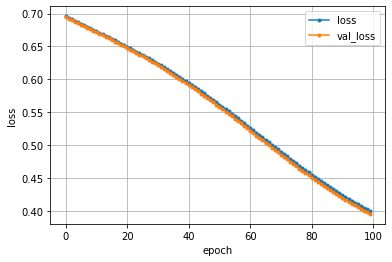

In [38]:
### 訓練過程の可視化
loss = his.history['loss']
val_loss = his.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [39]:
decoded_imgs_2 = autoencoder_2.predict(x_test)

313/313 [==============================] - 0s 1ms/step


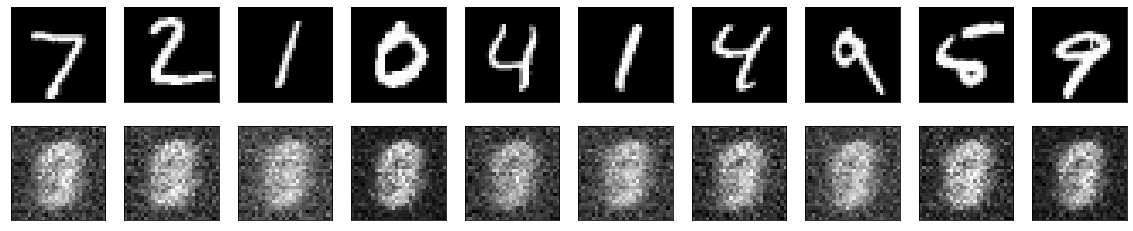

In [40]:
n = 10  # 横方向に描画する画像の数を設定
plt.figure(figsize=(20, 4))
for i in range(n):
    # オリジナルの画像データ
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # エンコード・デコードした画像データ
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_2[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**構築したモデルの構成とパラメータの保存**

In [41]:
import os

In [43]:
json_string = autoencoder_2.to_json()
open(os.path.join('','autoencoder.json'), 'w').write(json_string)

1366

In [44]:
autoencoder_2.save_weights(os.path.join('','autoencoder_weights.hdf5'))

In [45]:
!ls

architecture_simple2.png  autoencoder.json	    sample_data
architecture_simple.png   autoencoder_weights.hdf5


**モデル構成の読み込み**

In [46]:
from keras.models import model_from_json
json_string = open(os.path.join('','autoencoder.json')).read()
model = model_from_json(json_string)

In [47]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_4 (Dense)             (None, 1568)              1230880   
                                                                 
 dense_5 (Dense)             (None, 784)               1230096   
                                                                 
Total params: 2,460,976
Trainable params: 2,460,976
Non-trainable params: 0
_________________________________________________________________


**学習済のパラメータを読み込み**

In [48]:
model.compile(optimizer='adadelta', loss='binary_crossentropy')
model.load_weights(os.path.join('','autoencoder_weights.hdf5'))

In [49]:
decoded_imgs_2 = model.predict(x_test)

313/313 [==============================] - 0s 1ms/step


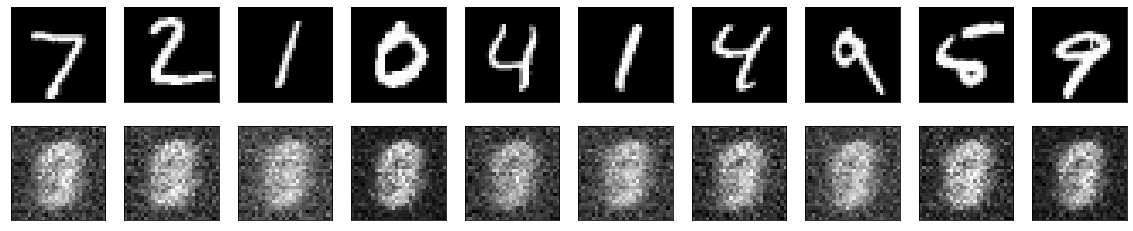

In [50]:
n = 10  # 横方向に描画する画像の数を設定
plt.figure(figsize=(20, 4))
for i in range(n):
    # オリジナルの画像データ
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # エンコード・デコードした画像データ
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_2[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**主成分分析との関係について**  
自己符号化器でどんな表現ができるかは、まずはネットワークの構造に依存します。  
※今回は多層自己符号化器(Deep Auto-Encoder)には触れないですが、このような取り組みがあることも表現の工夫を模索しているからです  
  
主に中間層のユニットの数($y$の成分数と一致)と、そこで用いる活性化関数に依存します。  
最も単純な場合として、中間層の活性化関数$f$が恒等写像の場合を考えます。  
$x$が実数値をとるものとし、出力層の活性化関数$\tilde f$にも恒等写像を選びます。このとき、中間層の出力は$y=Wx+b$のように計算され  
全体が表す写像は次のような線形写像となります。  
  
$$
\hat x = \tilde W(Wx+b)+\tilde b
$$
  
このネットワークの、中間層のユニット数を増減するとどのような影響があるかを上記で、直感的にみてきました。  
理論的に考えると、入力数のユニット数を$D_{x}$, 中間層のユニット数を$D_{y}$として、まず中間層が入力層より大きい($D_{y} \geq D_{x}$)場合  
を考えます。$W$は $D_{y} \times D_{x}$行列、$\tilde W$は $D_{x} \times D_{y}$であり、共に最大の[ランク(階数)](https://qiita.com/nognog/items/42f6a9e4839a7d8fbd63)は$D_{x}$となります。  
つまり、$\tilde W W$はサイズが$D_{x}\times D_{x}$、最大ランクは$D_{x}$となり、うまく成分を選択しさえすれば、  
  
$$
\tilde W W = I(単位行列)
$$
  
とできます。※単位行列になったということは、それだけ表現がシンプルになったと言える  
さらに、$b=\tilde b =0$と選べば、$x$によらず常に、入力と出力が一致($\tilde x = x$)することになります。
このとき、$E(w)$はいつも0になりますが、これは違和感を覚えます。(正確無比に訓練できていることを示すから)  
したがって、少なくとも活性化関数が線形関数の場合においては、意味のある結果を得るためには、  
中間層のユニット数が入力層よりも小さい($D_{y}	\leq D_{x}$)ことが必要条件となります。  
  
中間層が入力層より大きい($D_{y} \leq D_{x}$)場合、誤差関数$E(w)$を最小にする$W$および$\tilde W$は、訓練データ${x_{1}, ... , x_{n}}$の  
**主成分分析**(principal component analysis)で得られるものと実質的には同じとなります。  
主成分分析では、データの$D_{x}$次元空間の広がりを、訓練サンプル${x_{1}, ... , x_{n}}$の共分散行列  
  
$$
\Phi = \frac{1}{N} \sum_{n=1}^{N}(x_{n}-\bar x)(x_{n}-\bar x)^{T}
$$
  
の固有値・固有ベクトルによって捉えて、そしてデータの広がりを表現します。  
データがある低次元部分空間内にのみ偏って存在する場合、$\Phi$の固有値の大きなものから順に選択した固有ベクトルが、その部分空間を表します。  
  
固有値の降順に、$\Phi$の$D_{y}$個の固有ベクトルを選択したとき、これは行ベクトルとして格納した行列$U_{D_{y}}$を定義されます。  
この$U_{D_{y}}$および訓練サンプルの平均$\bar x$は、次の最小化問題の解$(\Gamma, \xi) = (U_{D_{y}}, \bar x)$になっています。  
  
$$
\min_{\Gamma, \xi} \sum_{n=1}^{N}\parallel (x_{n}-\xi) - \Gamma^{T} \Gamma (x_{n}-\xi) \parallel ^{2}
$$
  
このことから、主成分分析、つまり$\Phi$の固有値ベクトルは、$D_{x}$次元空間にある各サンプルを、二乗距離が最小になるという意味で  
最もよく表現する$D_{y}$次元部分空間を与えていると解釈できます。(シンプルに言えば、よく特徴を押さえている、ということ)  
  
この式は、自己符号化器の誤差関数と同じ形をしており、実際中間層の重みとバイアスをうまく選択すれば両者は全く同じ式になります。  
つまり、今考えている自己符号化器では、$(\Gamma, \xi) = (U_{D_{y}}, \bar x)$が、誤差関数を最小化するネットワークのパラメータを与えている  
ということになります。

# Sparse Auto-Encoder
**スパース正則化**  
**Sparse Autoencoder "activity_regularizer"**  
データの過完備な表現について説明していきます。  
上の例では、自己符号化器は入力データの特徴を学習しますが、一般に良い特徴とは、入力データの不要な情報を削ぎ落とし、その本質だけを  
取り出していくものです。そうであれば、入力データの成分数$D_{x}$よりも、それを符号化した符号が持つ成分数$D_{y}$は自ずと小さくなります。  
  
しかしいつもそうしなければならないわけではないです。  
スパース正則化を用いることで、余分な自由度を持つ冗長な特徴でありながらも、  
入力データをうまく表現できるような特徴を抽出できる場合があります。これを過完備な表現といいます。  
つまり、中間層が入力層より大きい($D_{y} \geq D_{x}$)場合であっても、自己符号化器で意味のある表現を学習できるようになります。  
これを**スパース自己符号化器**(sparse auto-encoder)と呼びます。

In [51]:
encoding_dim = 32
input_img = Input(shape=(784,))

# activity regularizerを加える
encoded = Dense(encoding_dim,
                activation='relu',
                activity_regularizer=regularizers.l1(0))(input_img)
decoded = Dense(784,
                activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
his = autoencoder.fit(x_train, x_train,
                      epochs=50,
                      batch_size=256,
                      shuffle=True,
                      validation_data=(x_test, x_test),
                      callbacks=[early_stopping])

Epoch 1/50
235/235 [==============================] - 1s 4ms/step - loss: 0.2771 - val_loss: 0.1886
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1693 - val_loss: 0.1519
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1431 - val_loss: 0.1327
Epoch 4/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1279 - val_loss: 0.1211
Epoch 5/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1182 - val_loss: 0.1130
Epoch 6/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1114 - val_loss: 0.1073
Epoch 7/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1065 - val_loss: 0.1032
Epoch 8/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1028 - val_loss: 0.1001
Epoch 9/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1001 - val_loss: 0.0977
Epoch 10/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0981 - val_loss: 0.0961

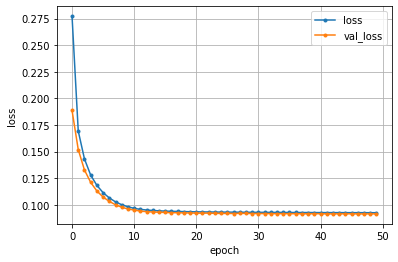

In [52]:
### 訓練過程の可視化
loss = his.history['loss']
val_loss = his.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [53]:
decoded_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 0s 1ms/step


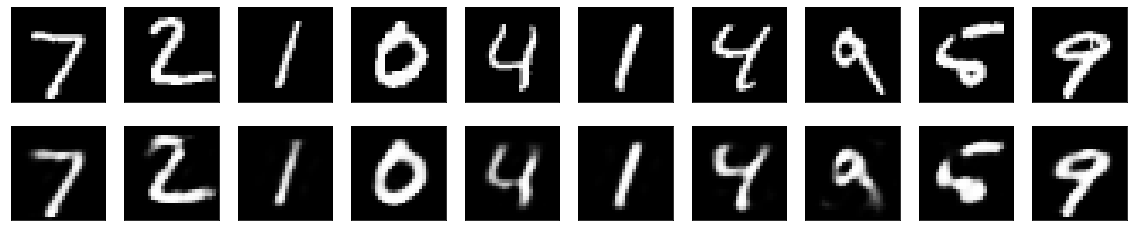

In [54]:
n = 10  # 横方向に描画する画像の数を設定
plt.figure(figsize=(20, 4))
for i in range(n):
    # オリジナルの画像データ
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # エンコード・デコードした画像データ
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**regularizers.l1(0)は、正則化の影響がゼロ。つまり、正則化していません。**

In [55]:
encoding_dim = 32
input_img = Input(shape=(784,))

# activity regularizerを加える
encoded = Dense(encoding_dim,
                activation='relu',
                activity_regularizer=regularizers.l1(0.1))(input_img)
decoded = Dense(784,
                activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
his = autoencoder.fit(x_train, x_train,
                      epochs=50,
                      batch_size=256,
                      shuffle=True,
                      validation_data=(x_test, x_test),
                      callbacks=[early_stopping])

Epoch 1/50
235/235 [==============================] - 1s 4ms/step - loss: 0.6621 - val_loss: 0.6155
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 0.5832 - val_loss: 0.5535
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 0.5275 - val_loss: 0.5038
Epoch 4/50
235/235 [==============================] - 1s 3ms/step - loss: 0.4827 - val_loss: 0.4638
Epoch 5/50
235/235 [==============================] - 1s 3ms/step - loss: 0.4466 - val_loss: 0.4314
Epoch 6/50
235/235 [==============================] - 1s 3ms/step - loss: 0.4174 - val_loss: 0.4050
Epoch 7/50
235/235 [==============================] - 1s 3ms/step - loss: 0.3935 - val_loss: 0.3834
Epoch 8/50
235/235 [==============================] - 1s 3ms/step - loss: 0.3739 - val_loss: 0.3656
Epoch 9/50
235/235 [==============================] - 1s 3ms/step - loss: 0.3577 - val_loss: 0.3508
Epoch 10/50
235/235 [==============================] - 1s 3ms/step - loss: 0.3442 - val_loss: 0.3385

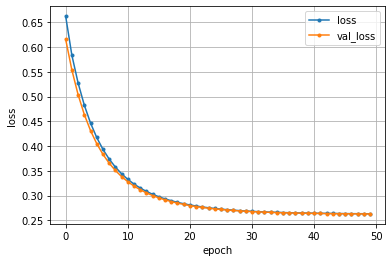

In [56]:
### 訓練過程の可視化
loss = his.history['loss']
val_loss = his.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [57]:
decoded_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 0s 1ms/step


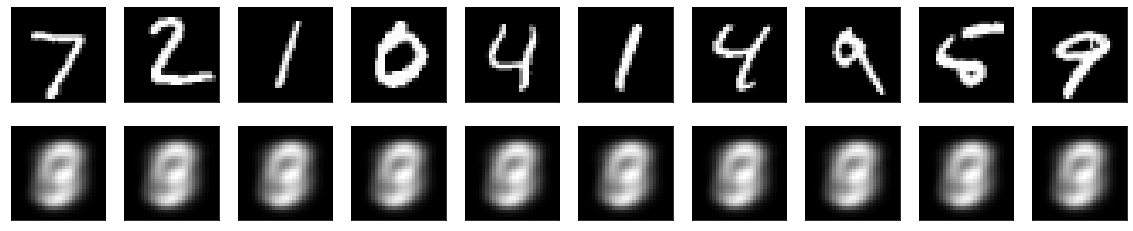

In [58]:
n = 10  # 横方向に描画する画像の数を設定
plt.figure(figsize=(20, 4))
for i in range(n):
    # オリジナルの画像データ
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # エンコード・デコードした画像データ
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [59]:
encoding_dim = 32
input_img = Input(shape=(784,))

# activity regularizerを加える
encoded = Dense(encoding_dim,
                activation='relu',
                activity_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5))(input_img)
decoded = Dense(784,
                activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
his = autoencoder.fit(x_train, x_train,
                      epochs=50,
                      batch_size=256,
                      shuffle=True,
                      validation_data=(x_test, x_test),
                      callbacks=[early_stopping])

Epoch 1/50
235/235 [==============================] - 1s 4ms/step - loss: 0.2842 - val_loss: 0.1968
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1765 - val_loss: 0.1573
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1483 - val_loss: 0.1386
Epoch 4/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1340 - val_loss: 0.1270
Epoch 5/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1240 - val_loss: 0.1186
Epoch 6/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1170 - val_loss: 0.1128
Epoch 7/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1120 - val_loss: 0.1087
Epoch 8/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1083 - val_loss: 0.1055
Epoch 9/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1057 - val_loss: 0.1034
Epoch 10/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1039 - val_loss: 0.1018

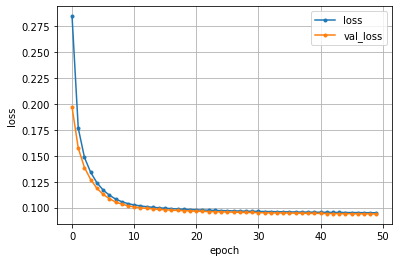

In [60]:
### 訓練過程の可視化
loss = his.history['loss']
val_loss = his.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [61]:
decoded_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 0s 1ms/step


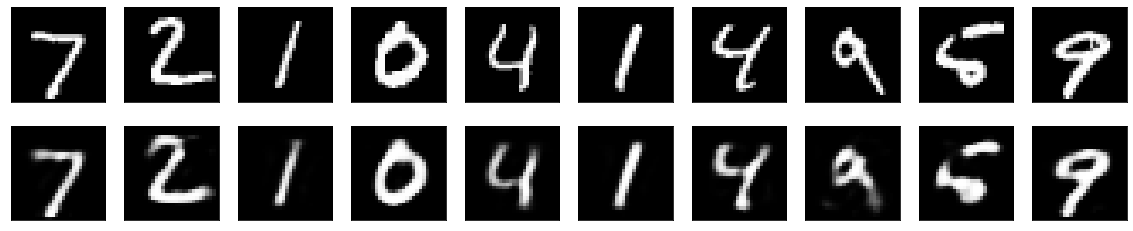

In [62]:
n = 10  # 横方向に描画する画像の数を設定
plt.figure(figsize=(20, 4))
for i in range(n):
    # オリジナルの画像データ
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # エンコード・デコードした画像データ
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 最後に、De-Noised Auto Encoderの紹介

In [63]:
import random

In [64]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 1, 28, 28))
x_test = np.reshape(x_test, (len(x_test), 1, 28, 28))

noise_factor = 0.35
# 平均0、標準偏差1の正規分布
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0., scale=1., size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0., scale=1., size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

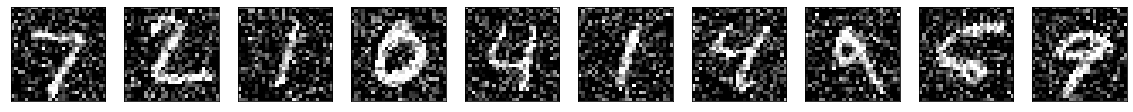

In [65]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [73]:
def denoise_autoencoder():
    from keras.layers import Activation, UpSampling2D
    from keras.layers import Conv2D, MaxPooling2D
    input_img = Input(shape=(1, 28, 28))
    x = Conv2D(32, kernel_size=(3, 3), padding='same', data_format='channels_first')(input_img)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_first')(x)
    x = Conv2D(32, kernel_size=(3, 3), padding='same', data_format='channels_first')(x)
    x = Activation('relu')(x)
    encoded = MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_first')(x)

    x = Conv2D(32, kernel_size=(3, 3), padding='same', data_format='channels_first')(encoded)
    x = Activation('relu')(x)
    x = UpSampling2D(size=(2, 2), data_format='channels_first')(x)
    x = Conv2D(32, kernel_size=(3, 3), padding='same', data_format='channels_first')(x)
    x = Activation('relu')(x)
    x = UpSampling2D(size=(2, 2), data_format='channels_first')(x)
    decoded = Conv2D(1, kernel_size=(3, 3), activation='sigmoid',padding='same', data_format='channels_first')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

In [74]:
autoencoder_denoise = denoise_autoencoder()

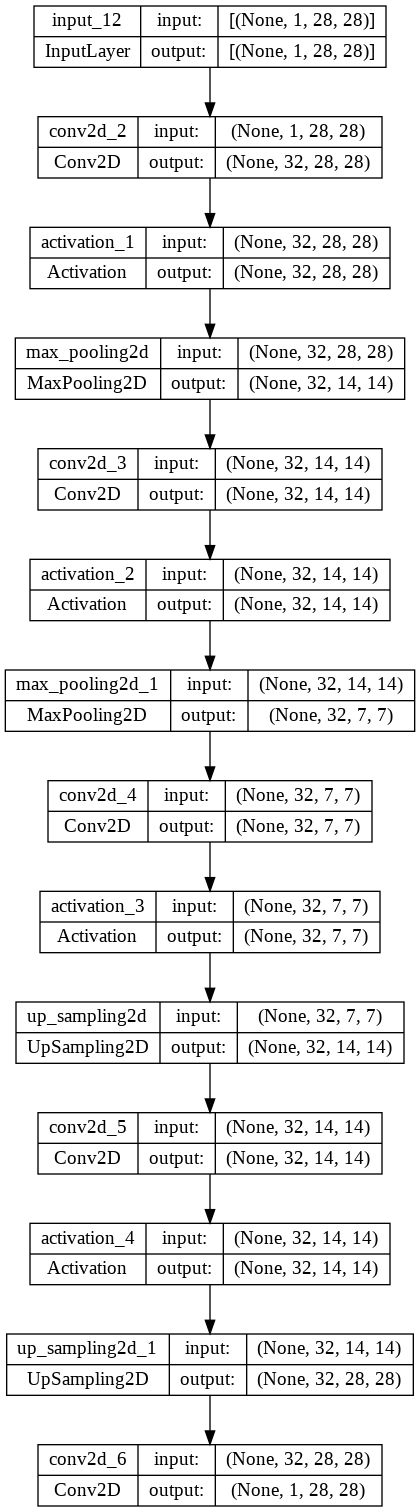

In [75]:
plot_model(autoencoder_denoise, to_file="architecture_denoise.png", show_shapes=True)

In [76]:
#from keras.callbacks import TensorBoard

his = autoencoder_denoise.fit(x_train_noisy, x_train,
                              epochs=10,
                              batch_size=256,
                              shuffle=True,
                              validation_data=(x_test_noisy, x_test),
                              callbacks=[early_stopping]
                             )

Epoch 1/10
235/235 [==============================] - 9s 12ms/step - loss: 0.1771 - val_loss: 0.1062
Epoch 2/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1014 - val_loss: 0.0963
Epoch 3/10
235/235 [==============================] - 3s 11ms/step - loss: 0.0954 - val_loss: 0.0924
Epoch 4/10
235/235 [==============================] - 2s 11ms/step - loss: 0.0923 - val_loss: 0.0902
Epoch 5/10
235/235 [==============================] - 2s 11ms/step - loss: 0.0904 - val_loss: 0.0886
Epoch 6/10
235/235 [==============================] - 2s 11ms/step - loss: 0.0889 - val_loss: 0.0875
Epoch 7/10
235/235 [==============================] - 2s 11ms/step - loss: 0.0879 - val_loss: 0.0871
Epoch 8/10
235/235 [==============================] - 2s 11ms/step - loss: 0.0870 - val_loss: 0.0859
Epoch 9/10
235/235 [==============================] - 2s 11ms/step - loss: 0.0863 - val_loss: 0.0855
Epoch 10/10
235/235 [==============================] - 2s 11ms/step - loss: 0.0858 - val_lo

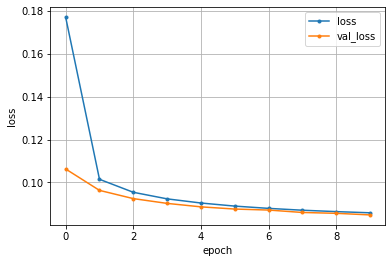

In [77]:
### 訓練過程の可視化
loss = his.history['loss']
val_loss = his.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [78]:
decoded_imgs = autoencoder_denoise.predict(x_test)

313/313 [==============================] - 1s 2ms/step


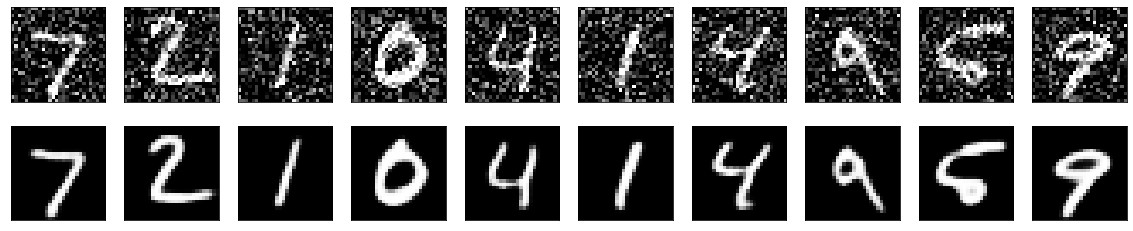

In [79]:
n = 10  # 横方向に描画する画像の数を設定
plt.figure(figsize=(20, 4))
for i in range(n):
    # オリジナルの画像データ
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # エンコード・デコードした画像データ
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Convolutional Autoencoder
畳み込みニューラルネットワーク（convolutional neural network, CNN）を使うことを考えます。

一般に、画像認識においてCNNは原始的なニューラルネットワーク（multilayer perceptron, MLP）よりも  
パフォーマンスが高いことが知られています。AutoencoderでもCNNを使うことにより、  
うまく学習できることが期待さている一方、Urban et al. 2016では、深さや畳み込みが本当に重要かどうかを実験により検証しています。  
この研究では、蒸留（distillation）という手法を使って学習させています。  

蒸留では教師モデルと生徒モデルを用意します。通常は訓練データの正解ラベルを使って学習しますが、  
蒸留ではこの正解ラベルではなく、教師モデルによる予測を正解ラベルとして生徒モデルを学習させます。  
生徒モデルは、教師モデルの予測結果と生徒モデルの予測結果とが最小となるよう学習していきます。  
（正解ラベルも両方使う場合があります。参考：Hinton et al. 2015）

通常の正解ラベルを使った学習では、例えば猫に関する訓練データであれば、  
猫以外のクラスに属する確率はゼロとして扱われます。しかし、  
教師モデルの予測では、猫である確率が一番高くとも、犬や虎である確率も僅かに存在しているはずです。  
生徒モデルは、ラベルとは異なる他のクラスである確率も含めて学習することになります。  

蒸留を行うと、生徒モデルは教師モデルよりも浅く小さなモデルであるにも関わらず、教師モデルと同等の正確度を出せることが分かっています。  
教師モデルの予測は、正解となるクラスだけでなく、それ以外のクラスに対する確率も含んでいるため、より多くの情報を持っていることになります。  
これにより、生徒モデルはうまく学習できると考えられます。

生徒モデルは教師モデルよりも小さなモデルなので、計算量が少なく、  
例えばサービスリリース時には蒸留を使って生徒モデルをデプロイする、などです。

Simple Auto-Encoderの例でみた通り、中間層が1層以上でもあれば表現力を持てるものの、  
うまく学習できるかどうかは別の問題です。今のところ、浅いニューラルネットワークに学習させる最も良い方法は蒸留だと考えられます。  
蒸留によって限界性能を引き出しつつ、層数や畳み込みによってどう正確度が変化するかを見れば、層数や畳み込みの重要性を  
ある程度見極めることができるでしょう。では実験結果を見てみましょう。

In [80]:
# coding: utf-8
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

input_img = Input(shape=(1, 28, 28))

x = Conv2D(16, kernel_size=(3, 3), padding='same', data_format='channels_first')(input_img)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_first')(x)
x = Conv2D(8, (3, 3), padding='same', data_format='channels_first')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_first')(x)
x = Conv2D(8, (3, 3), padding='same', data_format='channels_first')(x)
x = Activation('relu')(x)
encoded = MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_first')(x)

x = Conv2D(8, (3, 3), padding='same', data_format='channels_first')(encoded)
x = Activation('relu')(x)
x = UpSampling2D(size=(2, 2), data_format='channels_first')(x)
x = Conv2D(8, (3, 3), padding='same', data_format='channels_first')(x)
x = Activation('relu')(x)
x = UpSampling2D(size=(2, 2), data_format='channels_first')(x)
x = Conv2D(16, (3, 3), data_format='channels_first')(x)
x = Activation('relu')(x)
x = UpSampling2D(size=(2, 2), data_format='channels_first')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', data_format='channels_first')(x)

autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

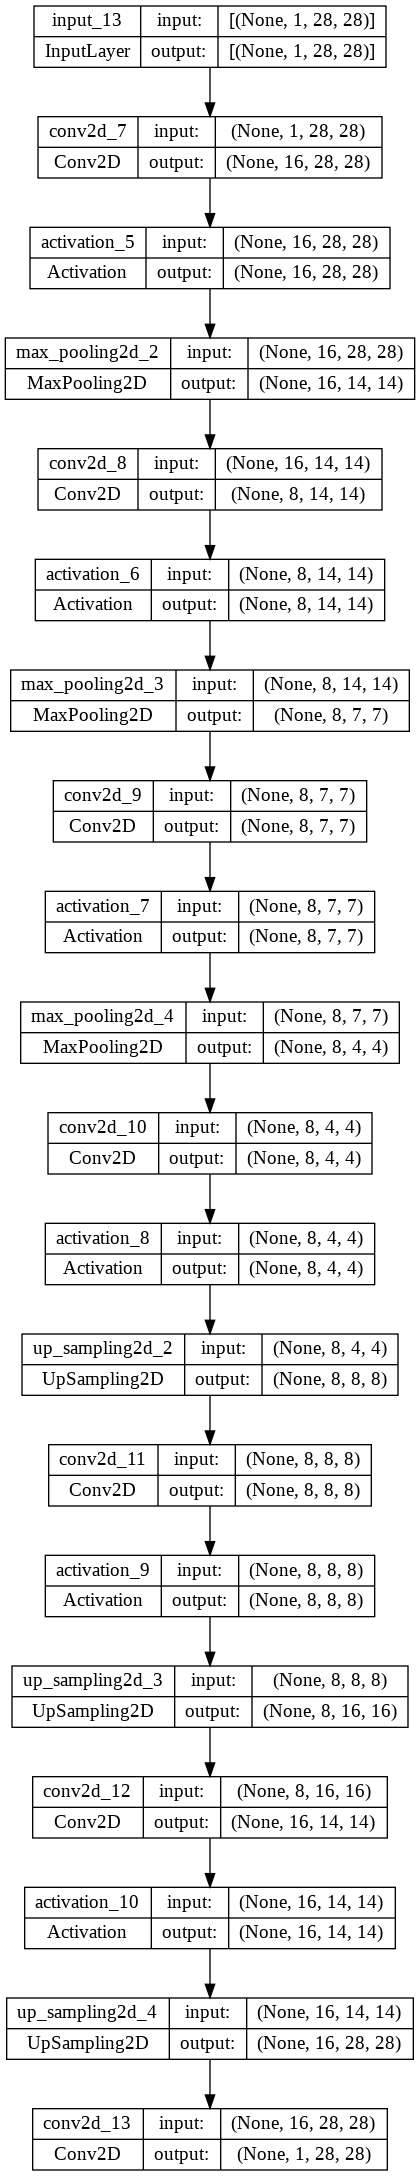

In [81]:
plot_model(autoencoder, to_file="architecture_cae.png", show_shapes=True)

**興味がある方は、このCAEも試してみてください(若干、訓練に時間がかかるかもしれません)**